<b>BERT tutorial: Classify spam vs no spam emails</b>

In [32]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text


Import the dataset (Dataset is taken from kaggle)


In [4]:
import pandas as pd

df = pd.read_csv("spam.csv", encoding='latin1')  # or encoding='ISO-8859-1'
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [16]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])


In [17]:
df = df.rename(columns={'v1': 'Category', 'v2': 'message'})


In [18]:
df.groupby('Category').describe()


message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [19]:
df['Category'].value_counts()


Category
ham     4825
spam     747
Name: count, dtype: int64

In [20]:
747/4825


0.15481865284974095

15% spam emails, 85% ham emails: This indicates class imbalance

In [21]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [22]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [23]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [24]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [25]:
df_balanced['Category'].value_counts()


Category
ham     747
spam    747
Name: count, dtype: int64

In [26]:
df_balanced.sample(5)

,Category,message
5098,spam,TheMob>Hit the link to get a premium Pink Pant...
4732,ham,Good Morning my Dear Shijutta........... Have ...
4217,ham,Actually i'm waiting for 2 weeks when they sta...
919,ham,Dont talk to him ever ok its my word.
3065,spam,Get a brand new mobile phone by being an agent...


In [27]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)


,Category,message,spam
1145,spam,"Thank you, winner notified by sms. Good Luck! ...",1
2043,spam,4mths half price Orange line rental & latest c...,1
4069,ham,Ok i wont call or disturb any one. I know all ...,0
1942,ham,K...k:)why cant you come here and search job:),0
334,spam,Valentines Day Special! Win over å£1000 in our...,1


Split it into training and test data set


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [30]:
X_train.head(4)


2790    UÛªve Bin Awarded å£50 to Play 4 Instant Cash...
3234                               Yes, princess. Toledo.
3008    Update_Now - 12Mths Half Price Orange line ren...
3213    Babe, have you got enough money to pick up bre...
Name: message, dtype: object

Now lets import BERT model and get embeding vectors for few sample statements


In [33]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [34]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.5132727 , -0.8884573 , ..., -0.7474888 ,
        -0.7531474 ,  0.91964483],
       [-0.8720835 , -0.50543964, -0.9444669 , ..., -0.85847497,
        -0.7174535 ,  0.8808299 ]], dtype=float32)>

In [35]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)


In [36]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.99110866]], dtype=float32)

In [37]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.76069164, -0.14219375,  0.4960462 , ...,  0.4216532 ,
        -0.5322139 ,  0.8031217 ],
       [-0.86023253, -0.21242967,  0.49156785, ...,  0.39797944,
        -0.6050633 ,  0.8447167 ],
       [-0.7128862 , -0.15463911,  0.38401607, ...,  0.3527872 ,
        -0.5099134 ,  0.7347411 ],
       [-0.82533485, -0.3555061 , -0.59069747, ..., -0.01613748,
        -0.61417586,  0.8723032 ],
       [-0.7504132 , -0.2681261 , -0.26689568, ...,  0.02839466,
        -0.59380955,  0.79749846],
       [-0.78544384, -0.299497  ,  0.41027313, ...,  0.5222541 ,
        -0.4957357 ,  0.8150751 ]], dtype=float32)>

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [41]:
cosine_similarity([e[3]],[e[4]])


array([[0.9872035]], dtype=float32)

In [42]:
cosine_similarity([e[0]],[e[3]])


array([[0.8470381]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

<b>Build Model</b>


There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [45]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [46]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [47]:
len(X_train)


1120

In [48]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [49]:
model.fit(X_train, y_train, epochs=10)


Epoch 1/10
35/35 [==============================] - 234s 6s/step - loss: 0.6194 - accuracy: 0.6902 - precision: 0.6852 - recall: 0.7036
Epoch 2/10
35/35 [==============================] - 225s 6s/step - loss: 0.5088 - accuracy: 0.8223 - precision: 0.8229 - recall: 0.8214
Epoch 3/10
35/35 [==============================] - 236s 7s/step - loss: 0.4345 - accuracy: 0.8518 - precision: 0.8373 - recall: 0.8732
Epoch 4/10
35/35 [==============================] - 264s 8s/step - loss: 0.3894 - accuracy: 0.8670 - precision: 0.8525 - recall: 0.8875
Epoch 5/10
35/35 [==============================] - 233s 7s/step - loss: 0.3649 - accuracy: 0.8741 - precision: 0.8643 - recall: 0.8875
Epoch 6/10
35/35 [==============================] - 237s 7s/step - loss: 0.3388 - accuracy: 0.8759 - precision: 0.8598 - recall: 0.8982
Epoch 7/10
35/35 [==============================] - 239s 7s/step - loss: 0.3278 - accuracy: 0.8839 - precision: 0.8694 - recall: 0.9036
Epoch 8/10
35/35 [==============================

In [50]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 75s 6s/step - loss: 0.2591 - accuracy: 0.9278 - precision: 0.9124 - recall: 0.9465


[0.2591165006160736,
 0.9278075098991394,
 0.9123711585998535,
 0.9465240836143494]

In [51]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 73s 6s/step


In [52]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,

In [53]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[170,  17],
       [ 10, 177]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

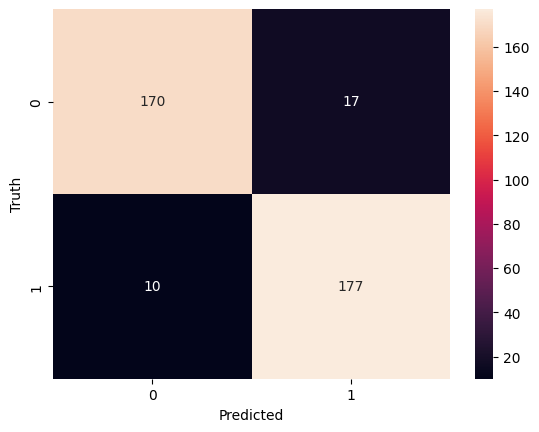

In [54]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [55]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       187
           1       0.91      0.95      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



In [56]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.7177073 ],
       [0.81979954],
       [0.7784372 ],
       [0.20632207],
       [0.07960063]], dtype=float32)